# Question 1: Build a CNN model


In [5]:
import torch
import torch.nn as nn
from torchinfo import summary
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Function to compute the image size after convolution and pooling
def compute_img_size(img_w, filter_size, padding, stride):
    return (img_w - filter_size + (2 * padding)) // stride + 1

class ConvNet(nn.Module):
    def __init__(self, in_channels=3, num_filters=[32, 64, 128, 256, 512],
                 filter_sizes=[3, 3, 5, 5, 7], activation='relu',
                 stride=1, padding=1, pool_size=2, fc_size=512, num_classes=10,
                 dropout=0.0, batch_norm=False, input_img_size=256):
        super(ConvNet, self).__init__()

        # Choose activation
        activation_dict = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }
        assert activation in activation_dict, f"Unsupported activation: {activation}"
        self.activation_fn = activation_dict[activation]

        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=2)

        layers = []
        img_size = input_img_size
        input_channels = in_channels

        for i in range(len(num_filters)):
            layers.append(nn.Conv2d(input_channels, num_filters[i], filter_sizes[i], stride=stride, padding=padding))
            if batch_norm:
                layers.append(nn.BatchNorm2d(num_filters[i]))
            layers.append(self.activation_fn)
            layers.append(self.pool)
            layers.append(nn.Dropout2d(dropout))

            img_size = compute_img_size(img_size, filter_sizes[i], padding, stride) // 2
            input_channels = num_filters[i]

        self.conv_layers = nn.Sequential(*layers)

        self.fc = nn.Linear(num_filters[-1] * img_size * img_size, fc_size)
        self.fc_bn = nn.BatchNorm1d(fc_size) if batch_norm else nn.Identity()
        self.dropout_fc = nn.Dropout(dropout)
        self.output_layer = nn.Linear(fc_size, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc_bn(x)
        x = self.activation_fn(x)
        x = self.dropout_fc(x)
        x = self.output_layer(x)
        return x
model=ConvNet().to(device)
summary(model, input_size=(1, 3, 256, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 5, 5]            --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─ReLU: 2-2                         [1, 32, 256, 256]         --
│    └─MaxPool2d: 2-3                    [1, 32, 128, 128]         --
│    └─Dropout2d: 2-4                    [1, 32, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 64, 128, 128]         18,496
│    └─ReLU: 2-6                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 64, 64, 64]           --
│    └─Dropout2d: 2-8                    [1, 64, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 128, 62, 62]          204,928
│    └─ReLU: 2-10                        [1, 128, 62, 62]          --
│    └─MaxPool2d: 2-11                   [1, 128, 31, 31]          --
│    

# Data load  form the directory and preproceesing by defing the functions.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
def data_load(data_dir, batch_size=64, val_split=0.2, data_augmentation=True):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]) if data_augmentation else transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader


In [9]:
def test_data_load(test_data_dir, data_augmentation='No'):
    # Transforms for resizing, normalization, etc.
    resize = transforms.Resize((256, 256))
    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    resize_crop = transforms.RandomResizedCrop(256)
    h_flip = transforms.RandomHorizontalFlip()
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rand_rotation = transforms.RandomRotation(20)

    if data_augmentation == 'Yes':
        transform_img = transforms.Compose([
            resize_crop,
            h_flip,
            color_jitter,
            rand_rotation,
            convert_to_tensor,
            normalize
        ])
    else:
        transform_img = transforms.Compose([
            resize,
            convert_to_tensor,
            normalize
        ])

    # Load dataset
    test_data = ImageFolder(root=test_data_dir, transform=transform_img)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    return test_loader


# model train function 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_train_val(model, train_loader, val_loader, epochs=5, learning_rate=1e-3):
    """
    Trains and validates the CNN model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        train_loss /= total
        train_acc = 100. * correct / total

        # Validation Phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= total
        val_acc = 100. * correct / total

        print(f"\nEpoch {epochs}/{epochs} => "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        
        wandb.log({
            'epoch+1': epochs + 1,
            'Train Loss': train_loss,
            'Train Accuracy': train_acc,
            'Validation Loss': val_loss,
            'Validation Accuracy': val_acc
        })

    print("Training complete!")
    return model  

   

# sweep for wandb 

In [11]:
import wandb

import random
# Login to Weights & Biases
wandb.login(key='594642013968a68e466138e783dcece6765c43b9')

sweep_config = {
    'method': 'bayes',  # Optimization strategy
    'metric': {
        'name': 'Validation Accuracy',  # Must match wandb.log()
        'goal': 'maximize'
    },
    'parameters': {
        'kernel_size': {
            'values': [
                [3, 3, 3, 3, 3],
                [3, 5, 5, 7, 7],
                [3, 5, 3, 5, 7],
                [5, 5, 5, 5, 5]
            ]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'activation': {
            'values': ['relu', 'mish', 'silu', 'gelu']
        },
        'num_dense': {
            'values': [128, 256]
        },
        'batch_norm': {
            'values': [True, False]
        },
        'filter_org': {
            'values': [
                [128, 128, 64, 64, 32],
                [32, 64, 128, 256, 512],
                [32, 32, 32, 32, 32],
                [32, 64, 64, 128, 128]
            ]
        },
        'data_aug': {
            'values': [True, False]
        },
        'epochs': {
            'values': [5, 10, 15]  # You can choose any range you want
        }
    }
}

# Register the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_2')


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bgorai005 (bgorai005-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: frb01d8p
Sweep URL: https://wandb.ai/bgorai005-iit-madras/Dl_assignment_2/sweeps/frb01d8p


In [7]:
def main():
    """
    This function will be called by W&B during the sweep.
    It sets up the model, dataloaders, and training loop based on sweep config.
    """

    with wandb.init() as run:
        config = wandb.config

        # Construct a readable run name
        run_name = (
            f"ks-{config.kernel_size}_drop-{config.dropout}"
            f"_daug-{config.data_aug}_fs-{config.filter_org}"
            f"_bn-{config.batch_norm}_dense-{config.num_dense}"
            f"_ep-{config.epochs}"
        )
        wandb.run.name = run_name

        # # Convert string batch norm to boolean
        # batch_norm = config.batch_norm == "Yes"

        # Build model
        model = ConvNet(
            in_channels=3,
            num_filters=config.filter_org,
            filter_sizes=config.kernel_size,
            stride=1,
            padding=1,
            pool_size=2,
            fc_size=config.num_dense,
            num_classes=10,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            input_img_size=256
        ).to(device)

        # Load data
        train_data_dir = "/kaggle/input/inaturalist/inaturalist_12K/train"
        # config = wandb.config
        # data_augmentation = True if config.data_aug == 'Yes' else False
        train_loader, val_loader = data_load(train_data_dir, data_augmentation=config.data_aug)

        # Train and validate model
        model_train_val(model, train_loader, val_loader, epochs=config.epochs)

    wandb.finish()
# Run the sweep agent
wandb.agent(sweep_id, function=main, count=1)
wandb.finish()


wandb: Agent Starting Run: mprcny6p with config:
wandb: 	activation: gelu
wandb: 	batch_norm: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	num_dense: 256


Epoch 1/15 [Val]: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]



Epoch 15/15 => Train Loss: 2.3011, Train Acc: 10.72%, Val Loss: 2.3001, Val Acc: 9.75%


Epoch 2/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]



Epoch 15/15 => Train Loss: 2.2997, Train Acc: 10.93%, Val Loss: 2.2996, Val Acc: 10.71%


Epoch 3/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]



Epoch 15/15 => Train Loss: 2.2917, Train Acc: 11.18%, Val Loss: 2.2965, Val Acc: 9.95%


Epoch 4/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]



Epoch 15/15 => Train Loss: 2.2803, Train Acc: 12.19%, Val Loss: 2.2883, Val Acc: 10.61%


Epoch 5/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]



Epoch 15/15 => Train Loss: 2.2805, Train Acc: 12.05%, Val Loss: 2.2863, Val Acc: 10.86%


Epoch 6/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]



Epoch 15/15 => Train Loss: 2.3007, Train Acc: 10.90%, Val Loss: 2.3036, Val Acc: 9.15%


Epoch 7/15 [Val]: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]



Epoch 15/15 => Train Loss: 2.3031, Train Acc: 10.15%, Val Loss: 2.3032, Val Acc: 9.10%


Epoch 8/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]



Epoch 15/15 => Train Loss: 2.3030, Train Acc: 9.60%, Val Loss: 2.3034, Val Acc: 9.15%


Epoch 9/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]



Epoch 15/15 => Train Loss: 2.3028, Train Acc: 9.80%, Val Loss: 2.3036, Val Acc: 9.15%


Epoch 10/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]



Epoch 15/15 => Train Loss: 2.3029, Train Acc: 9.68%, Val Loss: 2.3034, Val Acc: 9.10%


Epoch 11/15 [Val]: 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]



Epoch 15/15 => Train Loss: 2.3029, Train Acc: 9.95%, Val Loss: 2.3036, Val Acc: 9.15%


Epoch 12/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]



Epoch 15/15 => Train Loss: 2.3029, Train Acc: 9.96%, Val Loss: 2.3034, Val Acc: 9.10%


Epoch 13/15 [Val]: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]



Epoch 15/15 => Train Loss: 2.3028, Train Acc: 10.14%, Val Loss: 2.3033, Val Acc: 9.10%


Epoch 14/15 [Val]: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]



Epoch 15/15 => Train Loss: 2.3028, Train Acc: 9.44%, Val Loss: 2.3035, Val Acc: 9.15%


Epoch 15/15 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Epoch 15/15 => Train Loss: 2.3028, Train Acc: 10.11%, Val Loss: 2.3036, Val Acc: 9.10%
Training complete!


# hyperparameters of best models

In [12]:
num_filters=[32, 64, 128, 256,512]
filter_size=[3, 5, 5, 7, 7]
activation=nn.SiLU()
dense_size=128
dropout=0.2
batch_norm = True
data_augumentation = True
epochs = 15

# function for img plot

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_on_test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    test_loss = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= total
    test_acc = 100. * correct / total
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc



In [14]:

def img_plot(model):
    import os
    import cv2
    import random
    import torch
    import numpy as np
    import imageio
    import matplotlib.pyplot as plt
    from PIL import Image
    import wandb

    model.eval()
    classes_list = ['Amphibia','Animalia','Arachnida','Aves','Fungi',
                    'Insecta','Mammalia','Mollusca','Plantae','Reptilia']
    val_dir = '/kaggle/input/inaturalist/inaturalist_12K/train'
    images, labels, true_names = [], [], []

    # Select 3 random images per class (30 images total)
    for label_idx, class_name in enumerate(classes_list):
        class_dir = os.path.join(val_dir, class_name)
        sample_images = random.sample(os.listdir(class_dir), 3)
        for img_name in sample_images:
            img_path = os.path.join(class_dir, img_name)
            image = imageio.v2.imread(img_path)
            if np.ndim(image) == 3:
                image = cv2.resize(image, (256, 256))  # match model input
                images.append(image)
                labels.append(label_idx)
                true_names.append(class_name)

    # Preprocess
    arr = np.array(images).astype('float32') / 255.0
    arr = np.transpose(arr, (0, 3, 1, 2))  # NCHW
    tensor_input = torch.tensor(arr).to(device)

    # Predict
    with torch.no_grad():
        y_pred = model(tensor_input)
    predicted_indices = torch.argmax(y_pred, dim=1)

    # Create grid (10x3)
    fig, axes = plt.subplots(10, 3, figsize=(14, 30))
    fig.suptitle('10×3 Grid of Test Images with Predictions', fontsize=24, weight='bold', color='darkblue')

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            ax.imshow(images[idx])
            pred_class = classes_list[predicted_indices[idx].item()]
            true_class = true_names[idx]

            if pred_class == true_class:
                color = 'green'
            else:
                color = 'red'

            ax.set_title(f'True: {true_class}\nPred: {pred_class}', fontsize=10, color=color)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("grid_predictions.png", bbox_inches="tight")
    plt.show()

    # Log to wandb
    image = Image.open("grid_predictions.png")
    wandb.log({"Prediction Grid": wandb.Image(image, caption="10x3 Grid of Predictions")})


# run the best model to test the validation set and plot the images

In [15]:
import wandb

# Initialize your W&B run
wandb.init(
    project="DL_Assignment_2",         # Change this to your actual project name
    name="run-with-best-hparams",  # Optional: name of this run
    
)

model = ConvNet(
    in_channels=3,
    num_filters=num_filters,
    filter_sizes=filter_size,
    stride=1,
    padding=1,
    pool_size=2,
    fc_size=dense_size,
    num_classes=10,
    dropout=dropout,
    batch_norm=batch_norm,
    input_img_size=256
).to(device)

train_dir = '/kaggle/input/inaturalist/inaturalist_12K/train'
test_dir = '/kaggle/input/inaturalist/inaturalist_12K/val'
wandb
train_loader,val_loader = data_load(train_dir, data_augmentation=True)
test_loader = test_data_load(test_dir, data_augmentation='No')
# Train the model
trained_model =  model_train_val(model, train_loader, val_loader, epochs=25)
# Call the test function
evaluate_on_test(trained_model, test_loader)

Epoch 1/25 [Val]: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]



Epoch 25/25 => Train Loss: 2.1972, Train Acc: 19.38%, Val Loss: 2.0659, Val Acc: 27.11%


Epoch 2/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]



Epoch 25/25 => Train Loss: 2.0758, Train Acc: 25.94%, Val Loss: 1.9766, Val Acc: 29.46%


Epoch 3/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]



Epoch 25/25 => Train Loss: 2.0097, Train Acc: 28.38%, Val Loss: 1.9605, Val Acc: 30.42%


Epoch 4/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]



Epoch 25/25 => Train Loss: 1.9753, Train Acc: 29.94%, Val Loss: 1.9371, Val Acc: 31.12%


Epoch 5/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]



Epoch 25/25 => Train Loss: 1.9397, Train Acc: 31.19%, Val Loss: 1.9106, Val Acc: 31.87%


Epoch 6/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]



Epoch 25/25 => Train Loss: 1.9096, Train Acc: 32.23%, Val Loss: 1.9003, Val Acc: 33.82%


Epoch 7/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]



Epoch 25/25 => Train Loss: 1.8899, Train Acc: 32.85%, Val Loss: 1.8880, Val Acc: 33.97%


Epoch 8/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]



Epoch 25/25 => Train Loss: 1.8730, Train Acc: 34.20%, Val Loss: 1.8505, Val Acc: 35.92%


Epoch 9/25 [Val]: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]



Epoch 25/25 => Train Loss: 1.8510, Train Acc: 34.39%, Val Loss: 1.8549, Val Acc: 34.67%


Epoch 10/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]



Epoch 25/25 => Train Loss: 1.8158, Train Acc: 36.20%, Val Loss: 1.8557, Val Acc: 35.02%


Epoch 11/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]



Epoch 25/25 => Train Loss: 1.8006, Train Acc: 35.83%, Val Loss: 1.8333, Val Acc: 37.12%


Epoch 12/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]



Epoch 25/25 => Train Loss: 1.7795, Train Acc: 37.29%, Val Loss: 1.8242, Val Acc: 36.27%


Epoch 13/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]



Epoch 25/25 => Train Loss: 1.7447, Train Acc: 38.31%, Val Loss: 1.8229, Val Acc: 36.87%


Epoch 14/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]



Epoch 25/25 => Train Loss: 1.7210, Train Acc: 39.02%, Val Loss: 1.8256, Val Acc: 36.82%


Epoch 15/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]



Epoch 25/25 => Train Loss: 1.6888, Train Acc: 40.84%, Val Loss: 1.8261, Val Acc: 36.57%


Epoch 16/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]



Epoch 25/25 => Train Loss: 1.6769, Train Acc: 40.64%, Val Loss: 1.7936, Val Acc: 38.57%


Epoch 17/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]



Epoch 25/25 => Train Loss: 1.6383, Train Acc: 42.89%, Val Loss: 1.8119, Val Acc: 38.22%


Epoch 18/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]



Epoch 25/25 => Train Loss: 1.6035, Train Acc: 43.20%, Val Loss: 1.8120, Val Acc: 37.42%


Epoch 19/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]



Epoch 25/25 => Train Loss: 1.5797, Train Acc: 44.84%, Val Loss: 1.8224, Val Acc: 37.32%


Epoch 20/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]



Epoch 25/25 => Train Loss: 1.5300, Train Acc: 46.34%, Val Loss: 1.7856, Val Acc: 38.27%


Epoch 21/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]



Epoch 25/25 => Train Loss: 1.4722, Train Acc: 48.69%, Val Loss: 1.7945, Val Acc: 38.72%


Epoch 22/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]



Epoch 25/25 => Train Loss: 1.4175, Train Acc: 50.52%, Val Loss: 1.8184, Val Acc: 40.52%


Epoch 23/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]



Epoch 25/25 => Train Loss: 1.3859, Train Acc: 51.69%, Val Loss: 1.8371, Val Acc: 38.37%


Epoch 24/25 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]



Epoch 25/25 => Train Loss: 1.3138, Train Acc: 54.19%, Val Loss: 1.8763, Val Acc: 37.27%


Epoch 25/25 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]



Epoch 25/25 => Train Loss: 1.2550, Train Acc: 56.06%, Val Loss: 1.8792, Val Acc: 38.17%
Training complete!


Testing: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


Test Loss: 1.8419, Test Accuracy: 39.50%


(1.8418567962646484, 39.5)

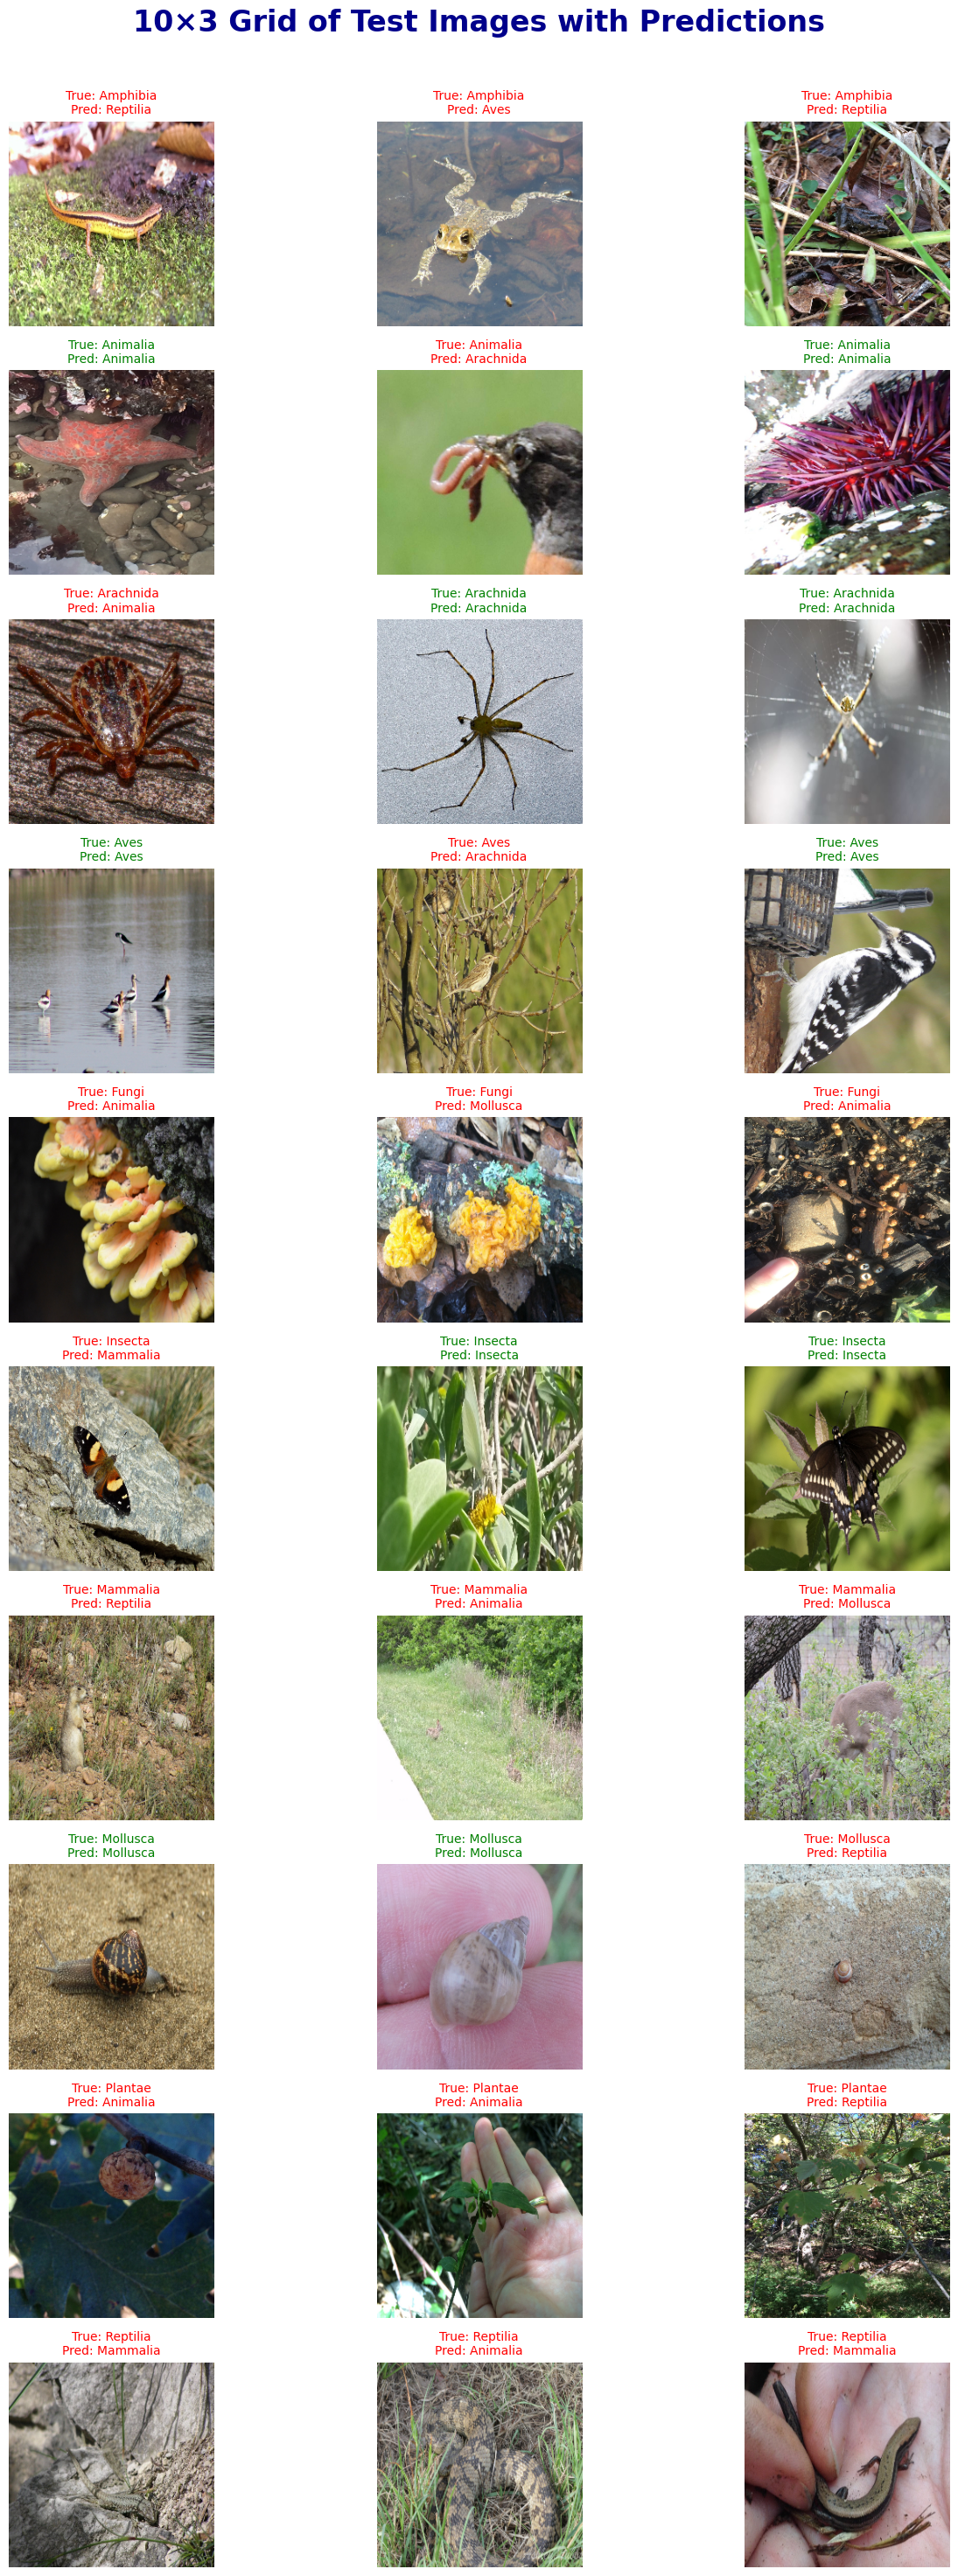

In [23]:
# calling function to plotting Image
img_plot(trained_model)

125
